In this notebook, we will study the change of different features along time.
These features can be 
- number of posts, weighted posts (using log upvotes number)
- topics 
- sentiment, total sentiment and sentiment for each topic

We also collect data of important dates when cdpr release new or videos from its website or youtube channel. We sort these dates manually according to the topics we have, and check the influences of these news on the sentiment changes.

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
import re
from datetime import date

In [122]:
## load data

posts_df = pd.read_csv('s_posts_8.csv', sep = ',', index_col = 'post_id')
posts_df.head(2)

,post_flair,post_title,post_date,post_url,post_body,post_up_votes,post_commentaries_count,post_awards_count,topic_0,topic_1,...,topic_5,topic_6,topic_7,loss,comments_date_range,post_title_sentiment_score,post_body_sentiment_score,log_comments_sentiment,topic,sentiment
post_id,,,,,,,,,,,,,,,,,,,,,
idqwwi,Cosplay,Walking Around Night City on November 19th Lik...,2020-08-21,https://v.redd.it/caa7ofozkai51,NaN,5805,13,1,0.054496,0.0,...,0.07613,0.049031,0.012814,0.900026,0.0,0.0000,0.0000,0.357489,4.0,0.357489
iv98fz,Question,PC Specs Megathread - Please use this thread t...,2020-09-18,https://www.reddit.com/r/cyberpunkgame/comment...,Hey Choombas\n\nDuring Night City Wire Epi...,763,52,8,0.000000,0.0,...,0.00000,0.000000,0.000000,0.680262,1.0,0.3182,0.6597,0.242845,2.0,0.659700


In [123]:
posts_df.columns

Index(['post_flair', 'post_title', 'post_date', 'post_url', 'post_body',
       'post_up_votes', 'post_commentaries_count', 'post_awards_count',
       'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
       'topic_6', 'topic_7', 'loss', 'comments_date_range',
       'post_title_sentiment_score', 'post_body_sentiment_score',
       'log_comments_sentiment', 'topic', 'sentiment'],
      dtype='object')

In [55]:
posts_df.post_date.sort_values()

post_id
idqwwi    2020-08-21
iv98fz    2020-09-18
j0sngm    2020-09-27
j294ea    2020-09-29
j2tllo    2020-09-30
             ...    
liyzpd    2021-02-13
ljmrjz    2021-02-14
ljq8fy    2021-02-14
ljh4mp    2021-02-14
ljkypq    2021-02-14
Name: post_date, Length: 1032, dtype: object

The posts are collected from 2020/8/21 to 2021/2/14, the cyberpunk game was released at 2020/12/10. Due to some techonical drawbacks, CD Projekt removed the game from Playstaion platform at later December. 

In [56]:
## here both date1 and date2 are strings
def str2num(s):
    if s[0] == '0':
        n_s = s.replace('0','',1)
        return int(n_s)
    else:
        return int(s)

def date_difference(date1, date2):
    a = '([0-9]{4})-([0-9]{2})-([0-9]{2})'
    (y1,m1,d1) = re.search(a, date1).groups()
    (y2,m2,d2)= re.search(a,date2).groups()
    y_diff = str2num(y2) - str2num(y1)
    m_diff = str2num(m2) -str2num(m1)
    d_diff = str2num(d2) - str2num(d1)

    ## change the difference to days, because the accuracy requirement is not so high
    ## so we assume 365 days per year
    days_month = (31,28,31,30,31,30,31,31,30,31,30,31)
    b = y_diff *12 + m_diff
    if b <= 0:
        return d_diff 
    else:
        sum = 0
        for i in range(b-1):
            sum += days_month[str2num(m1)-1+i]
        diff = sum + d_diff + days_month[(str2num(m2)-2)%12] 
        return diff 

In [57]:
# earliest date for collected posts
date0 = '2020-08-21'

# latest date for collected posts
date1 = '2021-02-14'

dates = pd.date_range(date0,date1)


177

In [147]:
## return the num of posts and the weighted (log(up_votes)) num of posts along time.
def num_posts_trend(posts_df, dates= dates):   
    posts_nums = np.zeros(len(dates))
    weights = np.zeros(len(dates))
    i = 0
    for d in dates:
        df = posts_df[posts_df['post_date'] == date.strftime(d, '%Y-%m-%d')]
        weights[i] = np.log(df['post_up_votes'].to_numpy()).sum()
        posts_nums[i] = (len(df))
        i+= 1
    return weights*posts_nums, posts_nums
        


In [183]:
weighted_posts_nums, posts_nums = num_posts_trend(posts_df)

In [128]:
## given a list a, return the n-day average
def n_day_average(a, n = 3):
    b = [a[-1]]*n
    new_a = a + b
    avg = np.zeros(len(new_a))
    for i in range(n):
        avg += np.roll(new_a,-i)
    avg = np.divide(avg, n)
    
    return avg[0:len(a)]


There are news posted on the official website of cyberpunk2077, the website link is here: https://www.cyberpunk.net/en/news/36071/your-night-city-cyberpunk-2077-illustration-contest

The dates are:
- 09/1/2020 night city art contest ; cyberpunk video on rtx
- 09/18/2020 hardware requirement; decorating PC contest result
- 10/15 game will release on some platform -- google stadia
- 10/20 cosplay contest finale
- 10/27 night city contest result (9/1)
- 11/14 song released
- 11/20 system requirement
- 11/23 copyright about songs in the game
- 12/3 release time announcement
- 12/9 photo contest
- 12/10 hardware update; game release
- 12/11 fix
- 12/14 apologize for bad performance and bugs, refund
- 12/18 suspend digital version on playstation 4, refund
- 12/19 fix
- 12/23 fix
- 01/13 apologize bad performance on console, commitment
- 01/22 patch
- 01/28 fix
- 2/5 fix
- 2/24 patch delay



The cyberpunk youtube channel also uploads videos
- 9/15 developers Q&A
- 9/3 song
- 9/18 games content
- 10/1 games content
- 10/3 gc (short for game content)
- 10/15 lots of gc videos and cosplay final
- 10/19 keanu ads about the game
- 11/13 song
- 11/14 song
- 11/17 xbox footage
- 11/19 song; official gameplay; lots of videos about developing and gc
- 11/24 ps gameplay
- 12/2 photo mode
- 12/8 launch trailer
- 12/9 more ads about the game
- 1/13 commitment


twitter

- 10/27 delay the release date to 12/10 (planed 11/19)
The above dates can be classified according to the 8 topics.





In [222]:
news_dates = [date(2020,9,1),date(2020,9,18),date(2020,10,9),date(2020,10,15),date(2020,10,20),date(2020,10,27),date(2020,11,14),date(2020,11,20),date(2020,11,23),
date(2020,12,3),date(2020,12,9),date(2020,12,10),date(2020,12,11),date(2020,12,14),date(2020,12,18),date(2020,12,19),date(2020,12,23),
date(2021,1,13),date(2021,1,22),date(2021,1,28),date(2021,2,5), date(2020,10,27)]
news_dates.sort()

video_dates = [date(2020,9,3),date(2020,9,15),date(2020,9,18),date(2020,10,1),date(2020,10,3),date(2020,10,15),date(2020,10,19),
date(2020,11,13),date(2020,11,17),date(2020,11,19),date(2020,11,14),date(2020,11,24),
date(2020,12,2),date(2020,12,8),date(2020,12,9),date(2021,1,13)]
video_dates.sort()

all_dates = list(set(news_dates + video_dates))
all_dates.sort()

big_dates = [date(2020,10,15),date(2020,11,19),date(2020,12,3),date(2020,12,10),date(2020,12,18),date(2021,1,13),date(2020,10,27)]
big_dates.sort()

In [221]:
company_news_dates = [date(2020,11,23),date(2020,12,3),date(2020,12,10),date(2020,12,14),date(2020,12,18),date(2021,1,13),
date(2020,9,15),date(2020,11,19),date(2020,10,27)]

## game contents works for topics 1 3 5 7
gc_dates = [date(2020,9,1),date(2020,9,3),date(2020,9,18),date(2020,10,1),date(2020,10,3),date(2020,10,15),date(2020,10,19),date(2020,11,13),date(2020,11,19),date(2020,11,14),date(2020,11,24),date(2020,12,8),date(2020,12,9), date(2020,12,10)]

## cosplay other art related to the game, topic 4
cosplay_dates = [date(2020,9,1),date(2020,9,18),date(2020,10,20),date(2020,10,27),date(2020,12,9),date(2020,10,15),date(2020,12,2)]

## hardware dates
hardware_dates = [date(2020,9,1),date(2020,9,18),date(2020,11,20),date(2020,11,17),date(2020,11,24)]

# release on platforms
release_dates = [date(2020,11,17),date(2020,11,24),date(2020,10,15),date(2020,12,3),date(2020,12,10),date(2020,12,14),date(2020,12,18),date(2020,10,27)]

# patch dates
patch_dates = [date(2020,12,11),date(2020,12,19),date(2020,12,23),date(2021,1,22),date(2021,1,28),date(2021,2,5)]


In [132]:
## here the parameter method can be 'prob' or ''.
# 'prob' means the topic for a document is computed by its topic distribution
# '' means the topic for a document is determined. It is determed as before
# the topics will not be weighted
def topic_trend(posts_df, method = '', num_topics = 8, dates = dates):
    topics = np.zeros((len(dates),num_topics))
    
    for i,d in enumerate(dates):
        # print(type(date))
        df = posts_df[posts_df['post_date']== date.strftime(d, '%Y-%m-%d')]
        #print(len(df))
        if method == '':
            a = df['topic'].value_counts()
            for k in range(num_topics):
                try:
                    topics[i,k] = a.loc[k]
                except:
                    topics[i,k] = 0

        elif method == 'prob':
            cols = ['topic_' + str(k) for k in range(num_topics)]
            topics[i,:] = df[cols].sum()
    
    return topics
    
        
        
    

In [133]:
topics = topic_trend(posts_df)

In [134]:
## the sentiment trend for each topic. Each post is weighted by log(up_votes), and its topic is
# determined as before

def sentiment_trend(posts_df,num_topics = 8, dates = dates):
    topic_sentiments = np.zeros((len(dates), num_topics))
    for i, d in enumerate(dates):
        df = posts_df[posts_df['post_date']== date.strftime(d,'%Y-%m-%d')]
        for k in range(num_topics):
            k_df = df[df['topic'] == k]
            weights = np.log(k_df['post_up_votes'].to_numpy())
            weights = np.divide(weights, weights.sum())
            topic_sentiments[i,k] = (k_df['sentiment'].to_numpy()*weights).sum()
    return topic_sentiments
            



In [136]:
sentiments = sentiment_trend(posts_df)

In [175]:
## visualization of trends
def trends_visualization(trend, label, important_dates,dates = dates, average_days = 3):
    ## to smooth the curve, we take the 3 day average. We allow the comments with date difference < 3
    plt.figure(figsize=(25,8))
    plt.bar(dates, trend, label = label,color = 'blue', alpha = 0.5)

    ## mark the important dates
    important_trend = [t for i,t in enumerate(trend) if dates[i] in important_dates]
    # print(len(important_dates))
    # print(len(important_trend))
    plt.bar(important_dates, important_trend, label = 'special dates', color = 'green')
    # plot 3-day average, after that day.
    plt.plot_date(dates, n_day_average(list(trend),average_days), label = str(average_days)+ '-day_avg', color = 'red', linestyle= 'solid')
    plt.legend()
    plt.xlabel('dates')
    plt.xticks(important_dates)
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%m-%d')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.show()
        

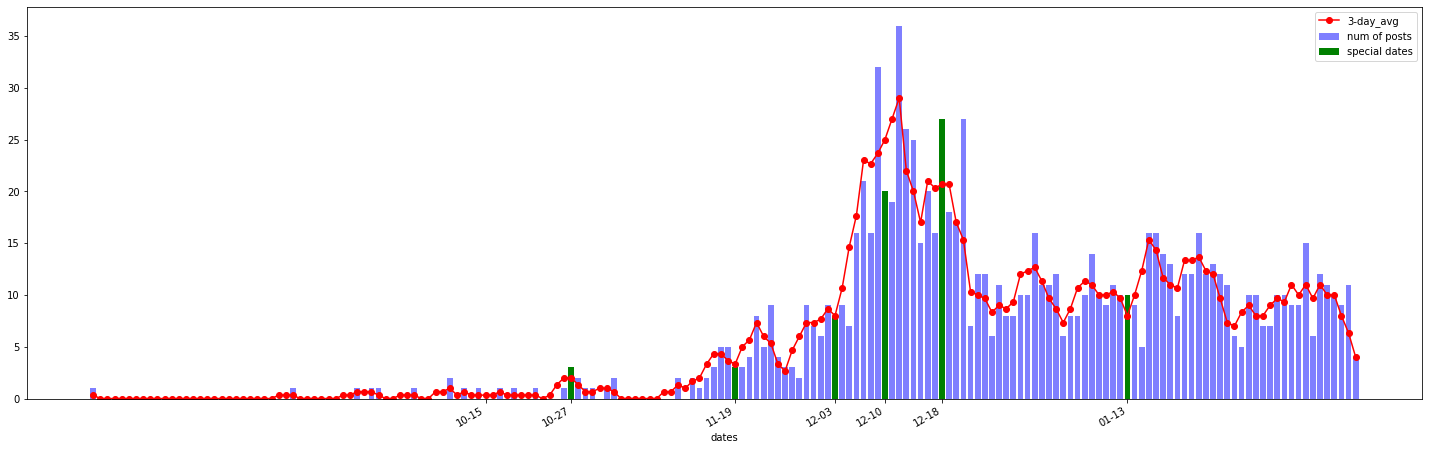

In [223]:
## post_number trends
trends_visualization(posts_nums, label = 'num of posts', important_dates = big_dates)

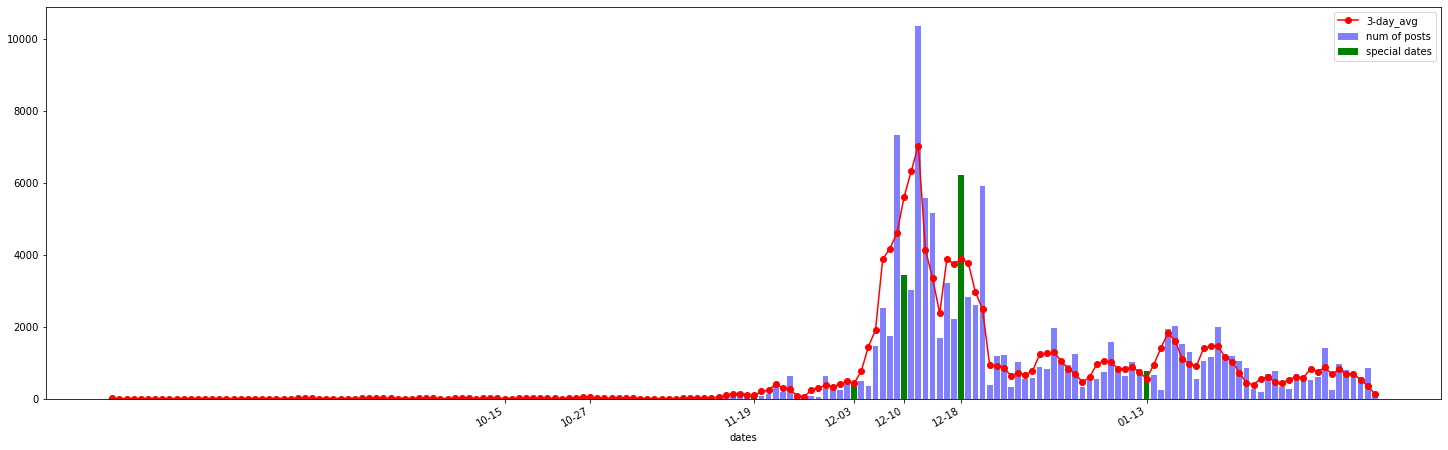

In [224]:
## weighted_post_number trends
trends_visualization(weighted_posts_nums, label = 'num of posts', important_dates = big_dates)

As we can see, when big news came out, there would be a significantly increase of the posts. 
These big dates are:
- 10-15, 11-19 lots of videos about game contents.
- 12-03 announcement of releasing date of the game
- 12-10 release of the game. The lay-back increasing of the posts is because it took some time to play the game
- 12-18 suspend of digital version distribution of the game on the platform
- 01-13 CDPR official apology about the bad quality of the game

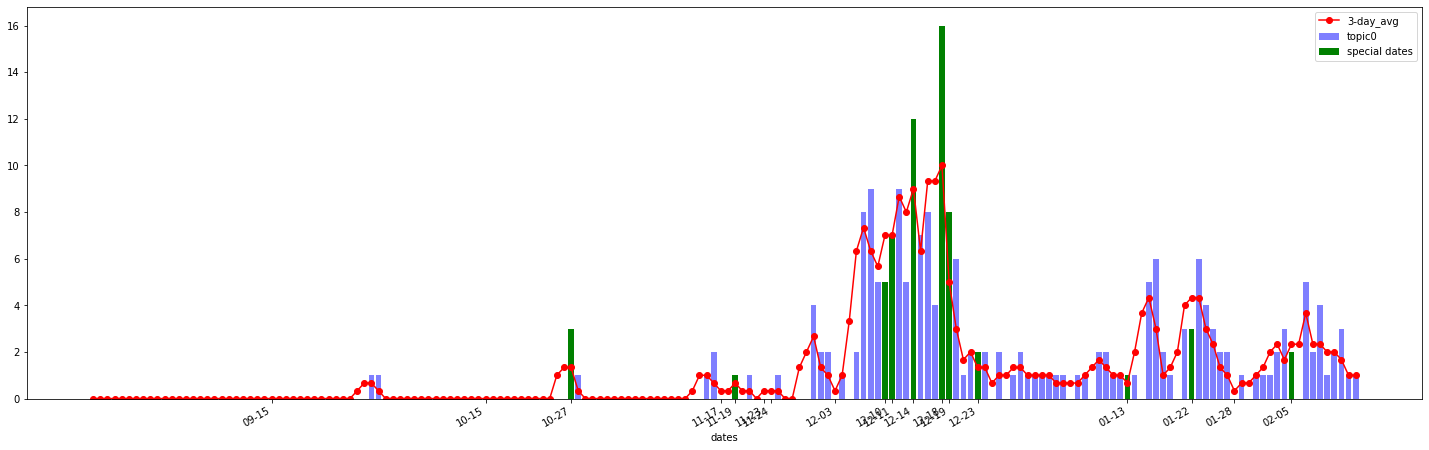

In [225]:
## topic0 is about the release of official news
## key_words = ['gen','content','story','issue','developer','lie','gta','marketing','devs','enjoy','people','management','product',
##'reviewer','rpg','launch','development','delay','year','witcher','hype','console','refund','promise','fix''company','bug','cdpr','release']

## the dates related to the topics are
topic0_dates = list(set(company_news_dates).union(set(release_dates)).union(patch_dates))
topic0_dates.sort()

trends_visualization(topics[:,0], label= 'topic0', important_dates = topic0_dates)

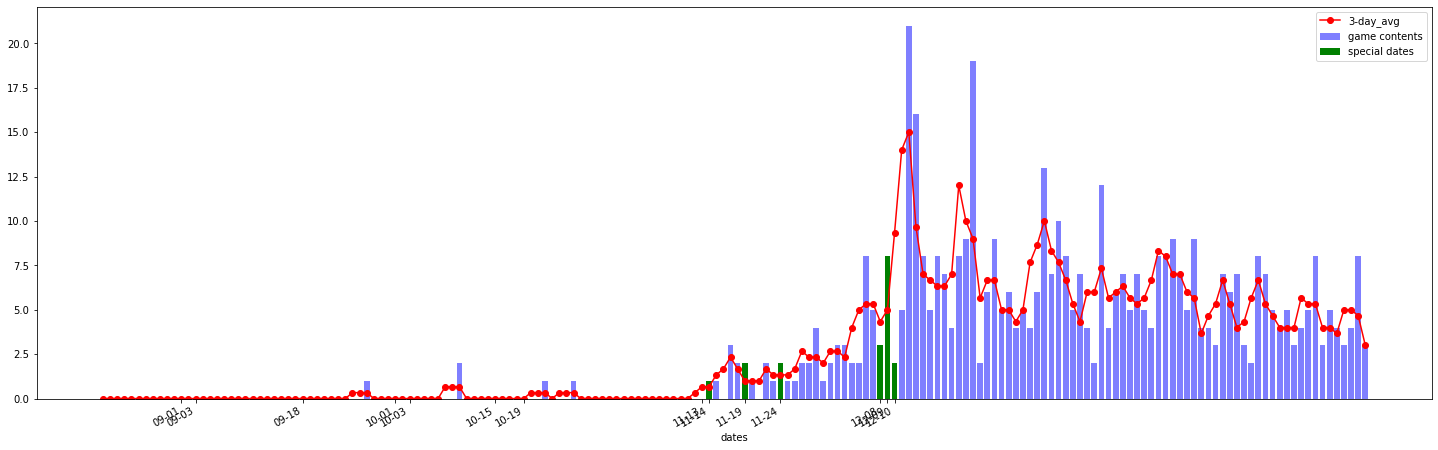

In [197]:
#### game contents works for topics 1 3 5 7, different aspects of game contents
### we add the topics together

# notice that it is hard to keep track of the contents after the game release
gc_topics = topics[:,1] + topics[:,3] + topics[:,5] + topics[:,7]

gc_dates.sort()
trends_visualization(gc_topics, label= 'game contents', important_dates = gc_dates)

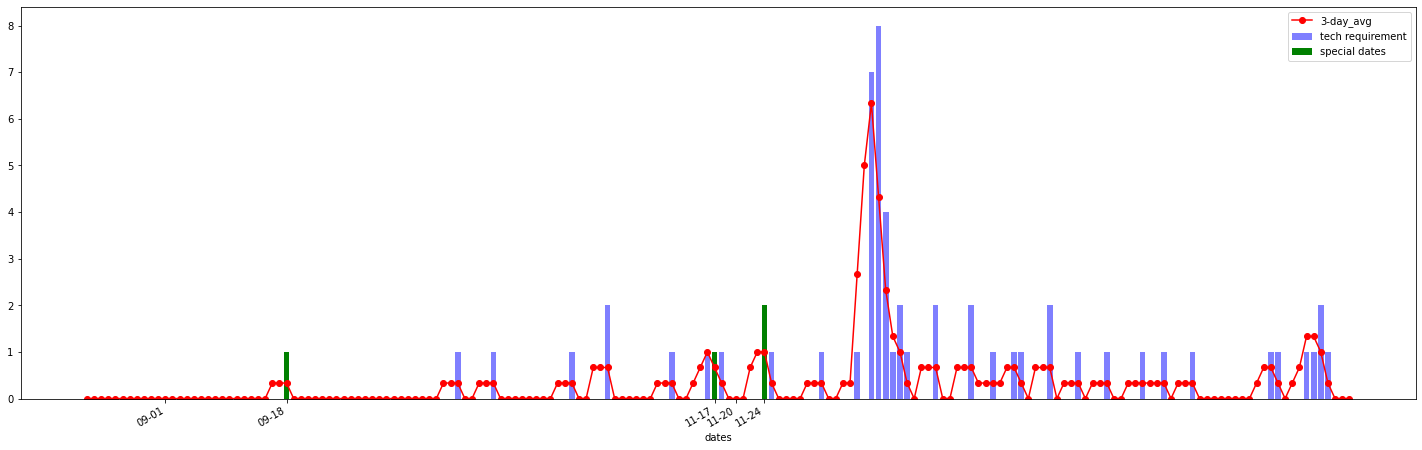

In [200]:
## topic2 is about the high requirement about the gameplay
hardware_dates.sort()

trends_visualization(topics[:,2], label = 'tech requirement', important_dates= hardware_dates)

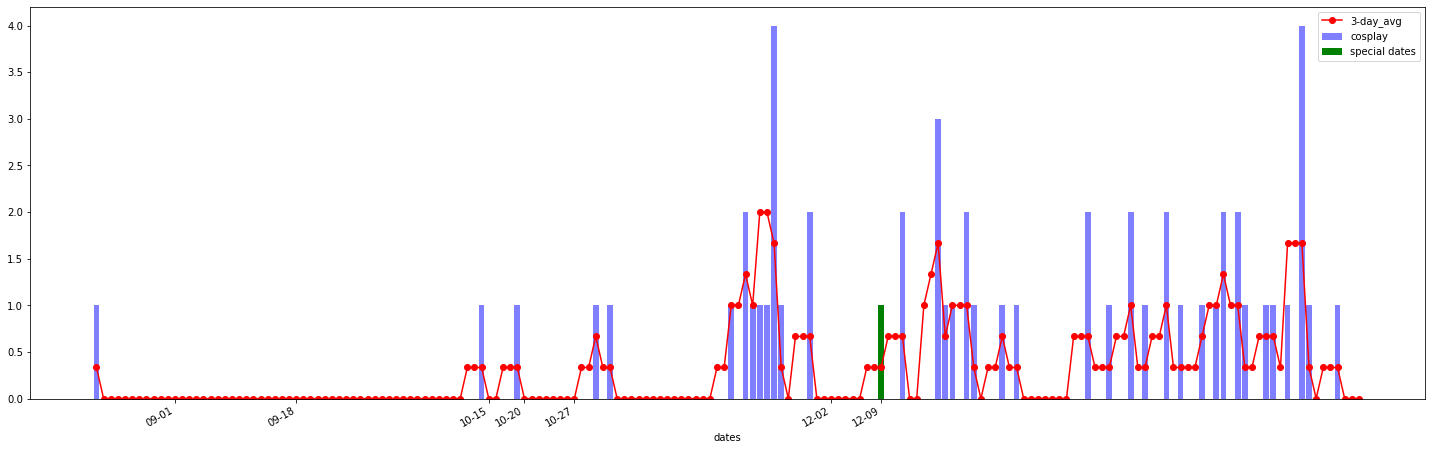

In [203]:
## topic4 is about the cosplay and also about the outfits of characters from the gameplay
cosplay_dates.sort()
trends_visualization(topics[:,4], label = 'cosplay', important_dates= cosplay_dates)

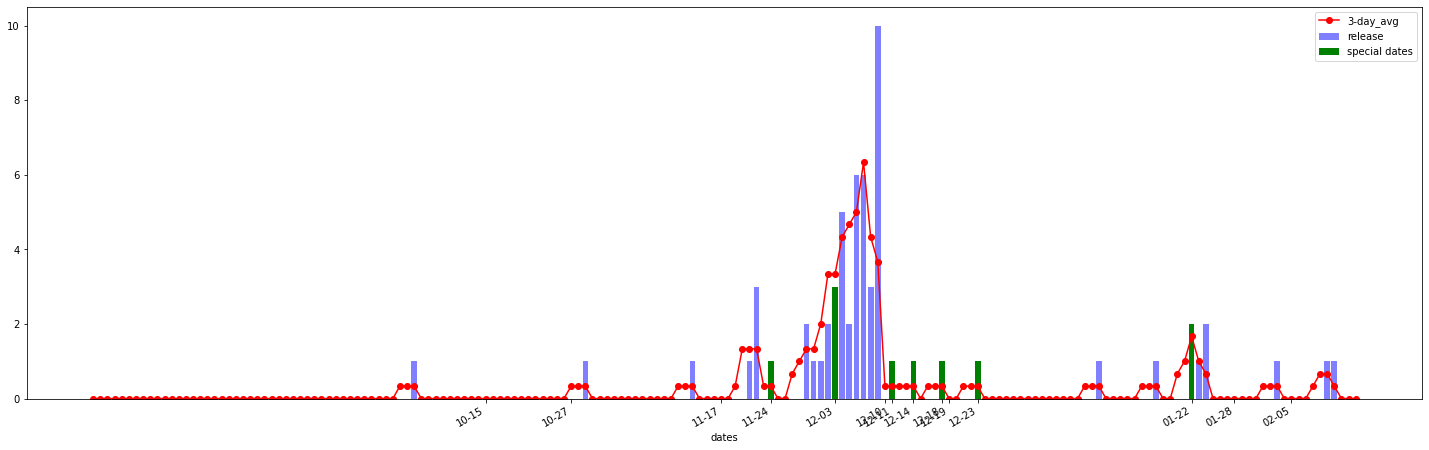

In [226]:
## topics7 is about the release of the game on various platforms, also the release of patches.
topic7_dates = list(set(release_dates + patch_dates))
topic7_dates.sort()
trends_visualization(topics[:,6], label= 'release', important_dates= topic7_dates)

From the trend above, we can find that the trends are 

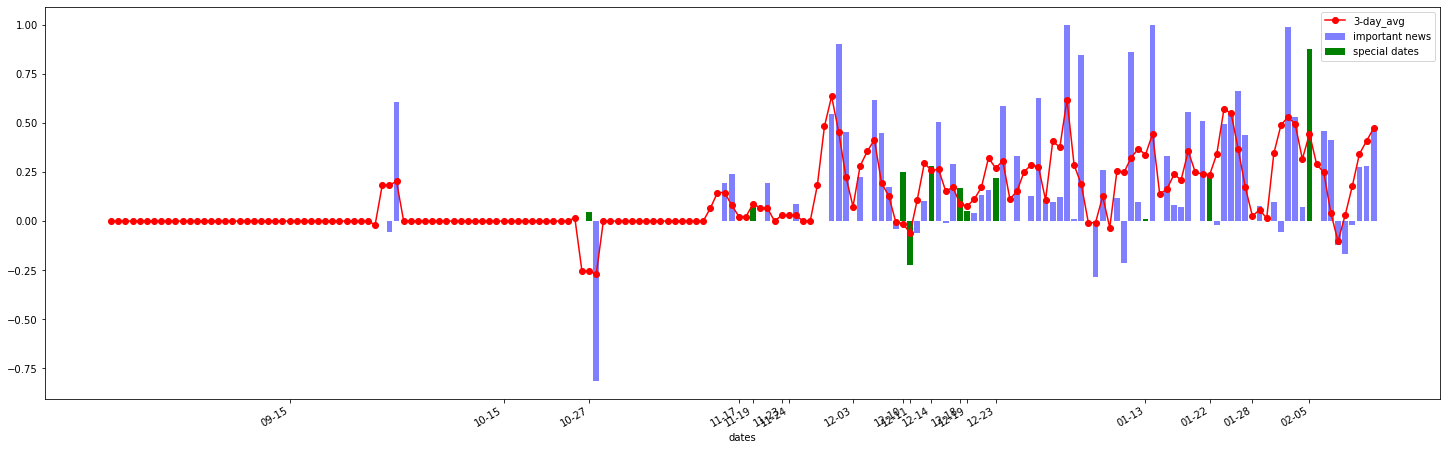

In [229]:
## on some days, there are no posts related to certain topics, how to do the visualization? 

trends_visualization(sentiments[:,0], label = 'important news, company', important_dates = topic0_dates)

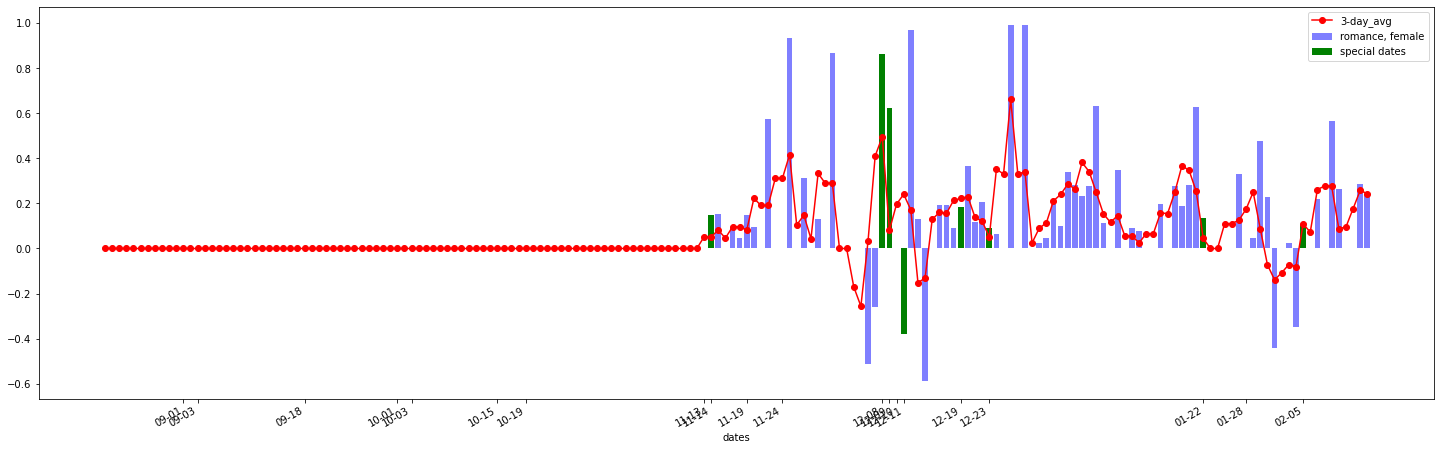

In [234]:

trends_visualization(sentiments[:,1],label = 'romance, female', important_dates= gc_dates + patch_dates)

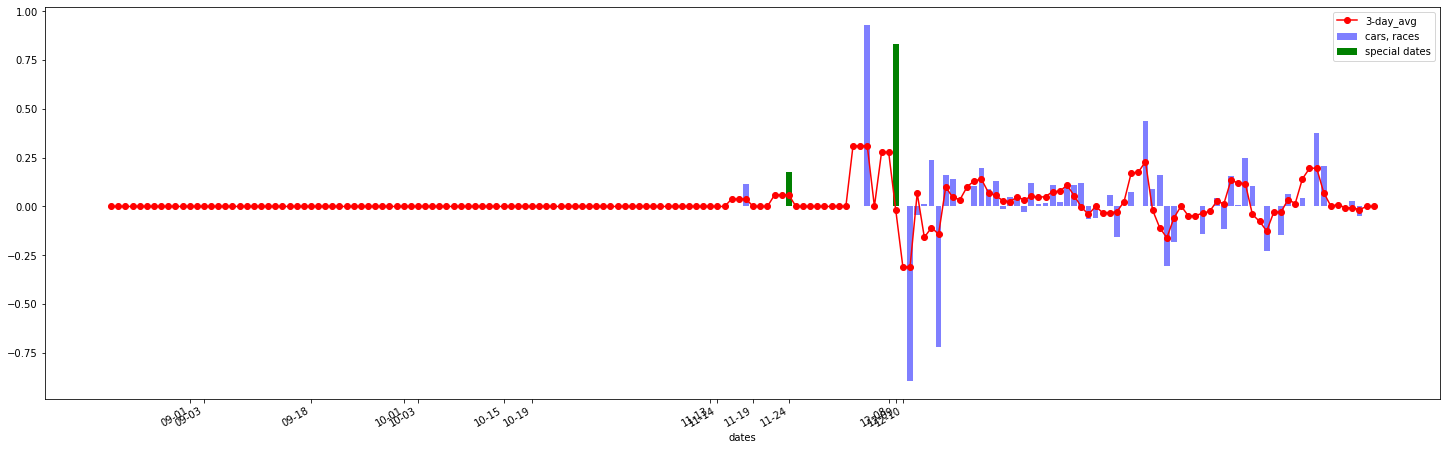

In [231]:
trends_visualization(sentiments[:,3],label = 'cars, races', important_dates=gc_dates )

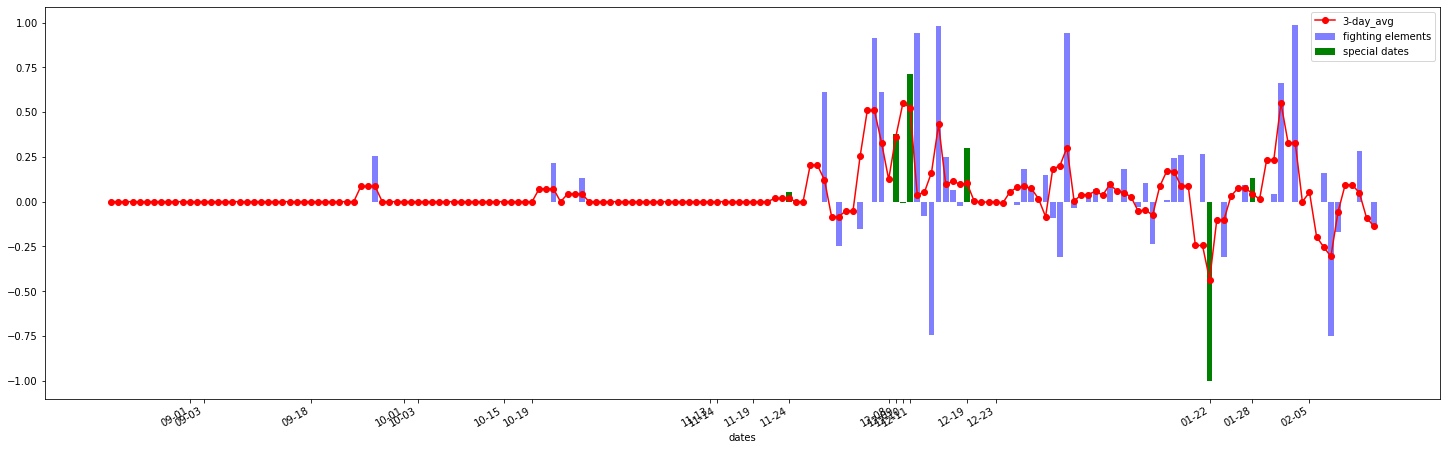

In [238]:
trends_visualization(sentiments[:,5],label = 'fighting elements', important_dates=gc_dates + patch_dates)

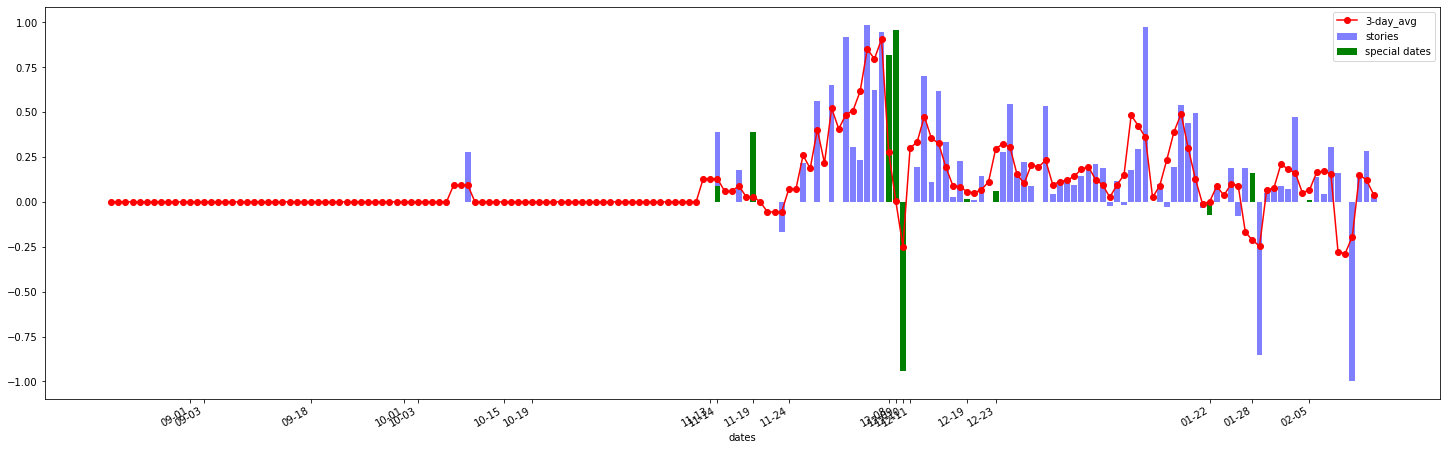

In [239]:
trends_visualization(sentiments[:,7],label = 'stories', important_dates=gc_dates + patch_dates )

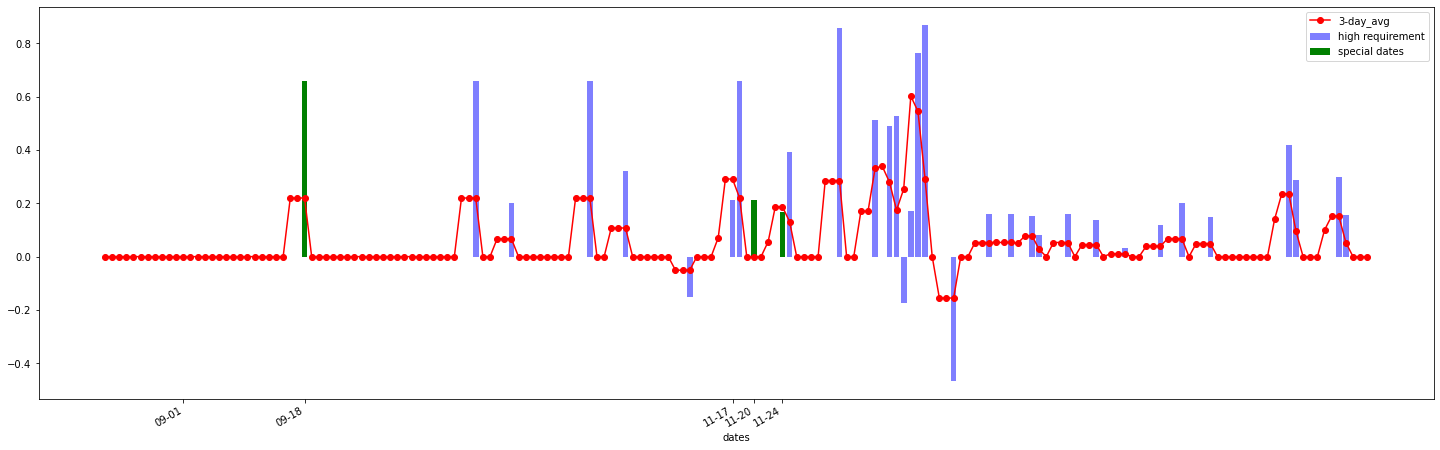

In [235]:
trends_visualization(sentiments[:,2],label = 'high requirement', important_dates= hardware_dates )

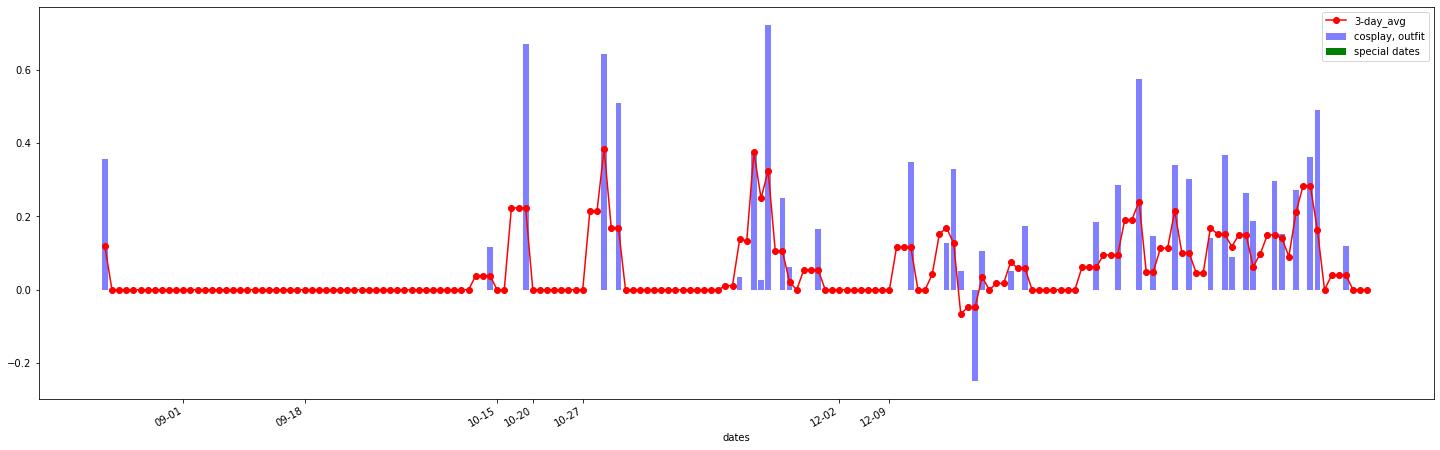

In [236]:
trends_visualization(sentiments[:,4],label = 'cosplay, outfit', important_dates= cosplay_dates )

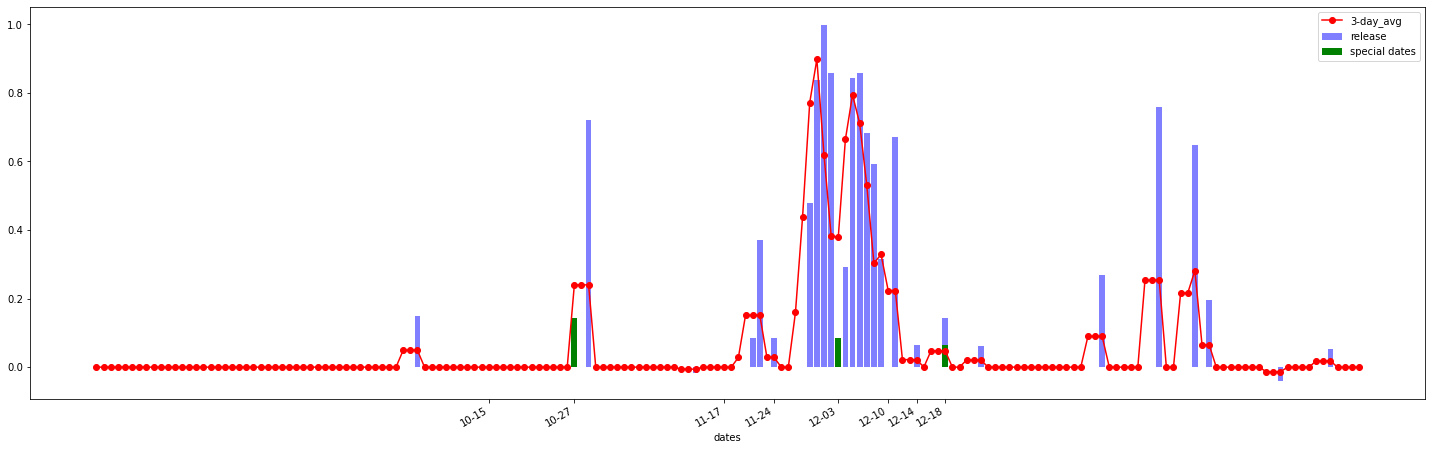

In [237]:
trends_visualization(sentiments[:,6],label = 'release', important_dates= release_dates )